# Recommendation System Using LLMs

## Custom Dataset Generation


---


# Initialization of IMBD Datasets


In [1]:
import pandas as pd

# Define the file paths for IMDB datasets
file_paths = {
    "DataSets/IMDB Datasets/title.akas.tsv": "akas_backup_df",
    "DataSets/IMDB Datasets/title.basics.tsv": "title_df",
    "DataSets/IMDB Datasets/title.episode.tsv": "episode_df",
    "DataSets/IMDB Datasets/title.ratings.tsv": "ratings_df"
}

# Importing the datasets into pandas DataFrames
for path, df_name in file_paths.items():
    globals()[df_name] = pd.read_csv(path, sep='\t', low_memory=False)
    print(f"Imported DataFrame: {df_name} from {path}")

print("Datasets Imported Successfully...")


Imported DataFrame: akas_backup_df from DataSets/IMDB Datasets/title.akas.tsv
Imported DataFrame: title_df from DataSets/IMDB Datasets/title.basics.tsv
Imported DataFrame: episode_df from DataSets/IMDB Datasets/title.episode.tsv
Imported DataFrame: ratings_df from DataSets/IMDB Datasets/title.ratings.tsv
Datasets Imported Successfully...


---


# Initial IMDB Dataset EDA


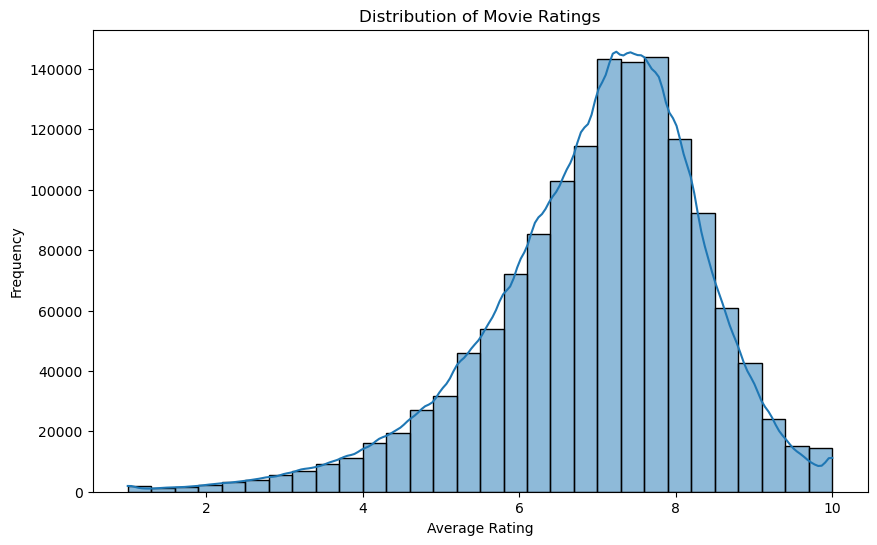

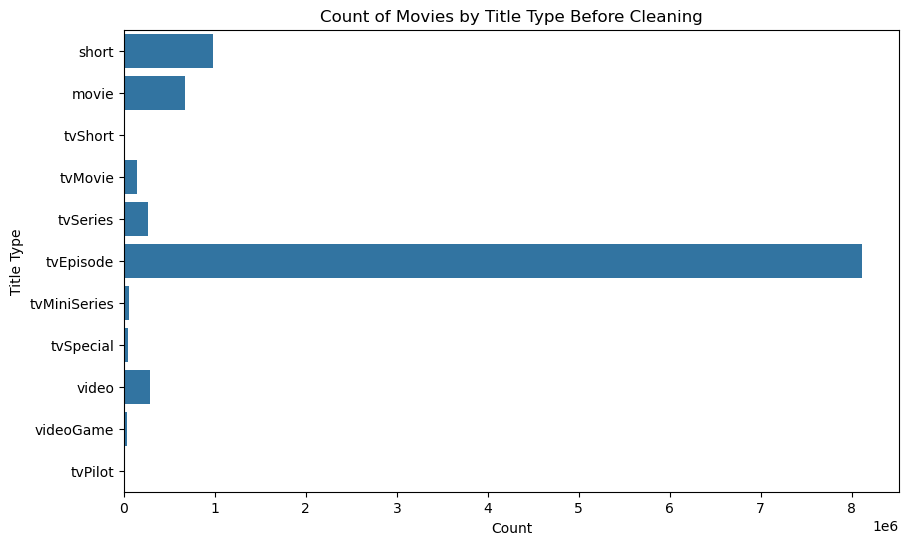

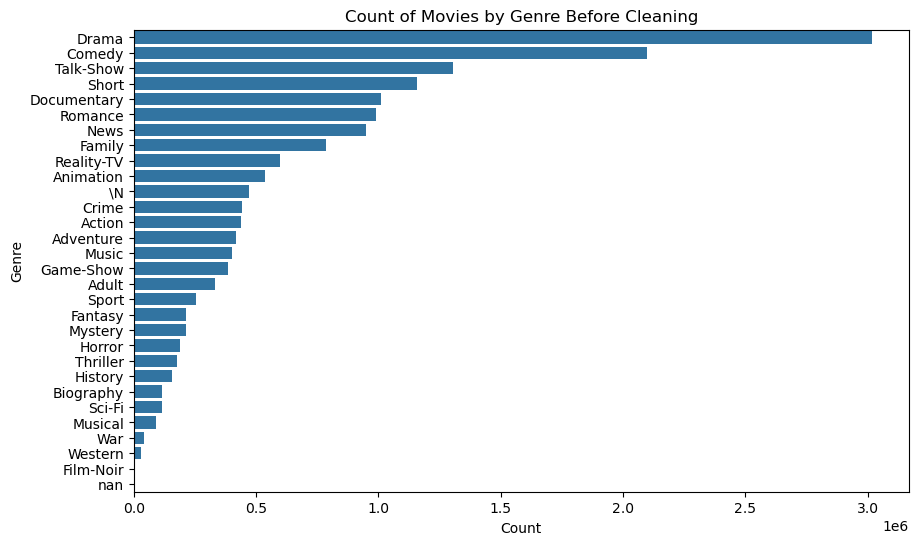

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings_df, x='averageRating', kde=True, bins=30)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Count of movies by title type before cleaning
plt.figure(figsize=(10, 6))
sns.countplot(data=title_df, y='titleType')
plt.title('Count of Movies by Title Type Before Cleaning')
plt.xlabel('Count')
plt.ylabel('Title Type')
plt.show()

# Count of movies by genre (note: this requires splitting the genres column as movies can have multiple genres)
title_df['genres'] = title_df['genres'].astype(str).apply(lambda x: x.split(','))
genres_df = title_df.explode('genres')
plt.figure(figsize=(10, 6))
sns.countplot(data=genres_df, y='genres', order=genres_df['genres'].value_counts().index)
plt.title('Count of Movies by Genre Before Cleaning')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


---


# Preprocessing IMDB Dataset


In [3]:
# Prepare the akas DataFrame by making a copy for manipulation
akas_df = akas_backup_df.copy()

# Drop unnecessary columns from akas_df
akas_df.drop(columns=['ordering', 'title', 'attributes', 'isOriginalTitle'], inplace=True)

# Initialize a list of 'types' values to exclude
types_to_drop = ['alternative', 'festival', 'dvd', 'video', 'alternative\x02tv', 'festival\x02imdbDisplay',
                 'alternative\x02dvd', 'dvd\x02imdbDisplay', 'video\x02working', 'festival\x02working',
                 'dvd\x02video', 'alternative\x02festival', 'alternative\x02video', 'alternative\x02working']

# Exclude rows with specified 'types'
akas_df = akas_df[~akas_df['types'].isin(types_to_drop)]

# Sort akas_df by 'titleId' and 'types' with special handling for '\\N'
akas_df.sort_values(by=['titleId', 'types'], ascending=[True, False],
                    key=lambda col: col.replace('\\N', 'zz'), inplace=True)

# Drop duplicate 'titleId' entries, keeping the first occurrence
akas_df.drop_duplicates(subset='titleId', keep='first', inplace=True)

# Further clean up by removing no longer needed columns
akas_df.drop(columns=['types'], inplace=True)


In [4]:
# Extract unique 'tconst' identifiers from episode_df
tconst_list = episode_df['tconst'].unique().tolist()

# Remove rows in akas_df where 'titleId' matches any 'tconst' from the list
akas_df = akas_df[~akas_df['titleId'].isin(tconst_list)]

# Identify adult titles from title_df
adult_title_ids = title_df[title_df['isAdult'] == '1']['tconst'].tolist()

# Exclude adult titles from akas_df
akas_df = akas_df[~akas_df['titleId'].isin(adult_title_ids)]

# Rename 'titleId' column to 'tconst' for consistency
akas_df = akas_df.rename(columns={'titleId': 'tconst'})

# Prepare the title_df by dropping unnecessary columns
title_df.drop(columns=['runtimeMinutes', 'originalTitle', 'isAdult'], inplace=True)


In [5]:
# Merge akas_df with title_new_df and ratings_df to create a final DataFrame
df = akas_df.merge(title_df, on='tconst', how='left').merge(ratings_df, on='tconst')

# Initialize a list of 'titleType' values to exclude
titleType_to_drop = ['short', 'tvShort', 'tvEpisode', 'tvMiniSeries', 'tvSpecial', 'video', 'videoGame']

# Exclude rows with specified 'titleType'
df = df[~df['titleType'].isin(titleType_to_drop)]

# Select specific columns for the final DataFrame
df = df[['tconst', 'titleType', 'primaryTitle', 'startYear', 'endYear', 'genres', 'language', 'region', 'averageRating', 'numVotes']]


---


# Custom Dataset Visualization


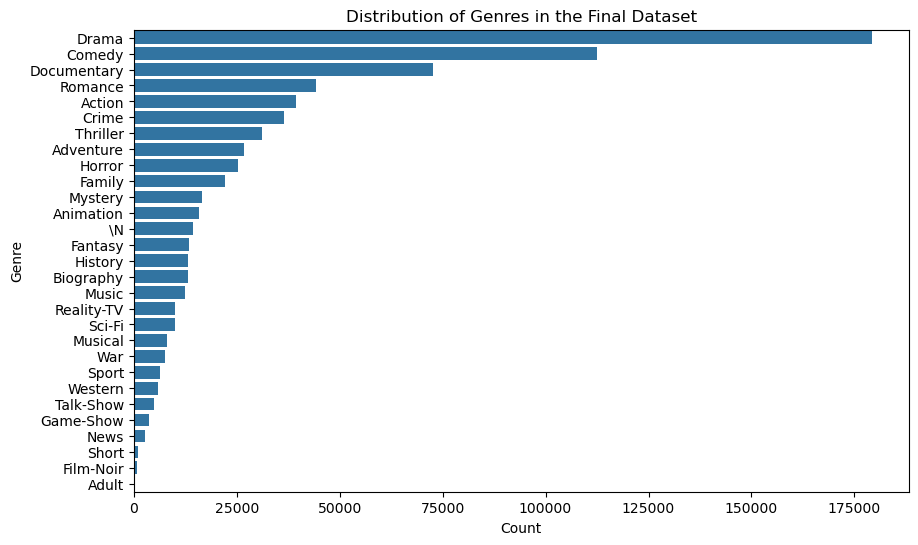

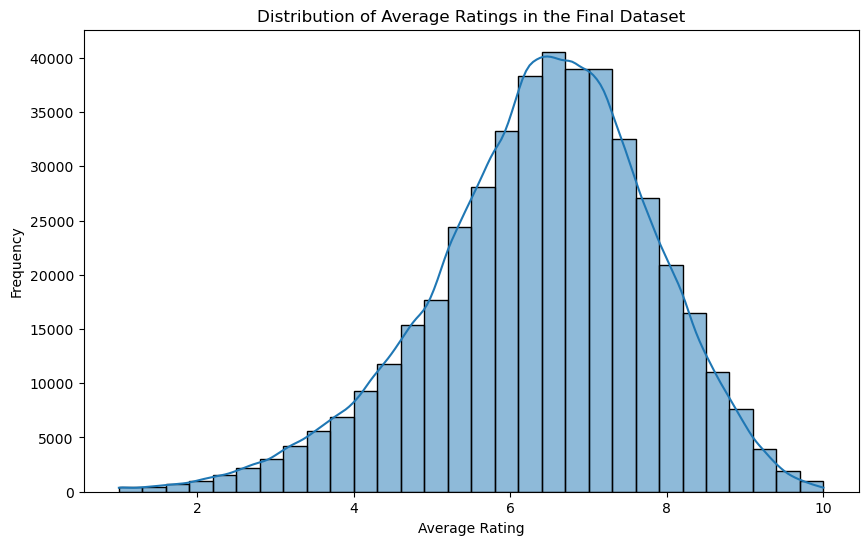

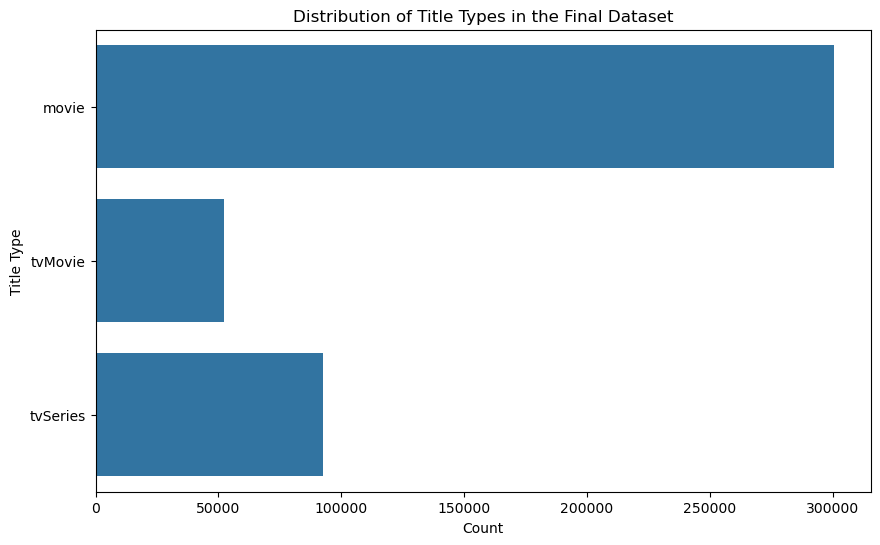

In [6]:
# Convert the Series to DataFrame for visualization
final_genres_df = df['genres'].explode().to_frame()

# Now, you can use seaborn's countplot with the DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=final_genres_df, y='genres', order=final_genres_df['genres'].value_counts().index)
plt.title('Distribution of Genres in the Final Dataset')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# Distribution of average ratings in the final dataset
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='averageRating', kde=True, bins=30)
plt.title('Distribution of Average Ratings in the Final Dataset')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Distribution of title types in the final dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='titleType')
plt.title('Distribution of Title Types in the Final Dataset')
plt.xlabel('Count')
plt.ylabel('Title Type')
plt.show()


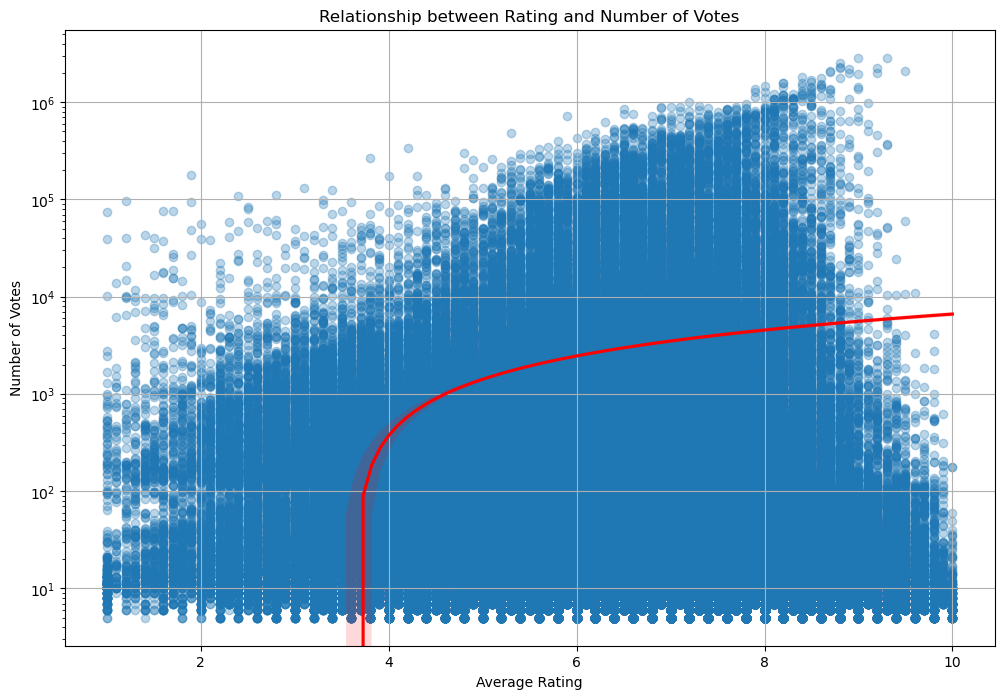

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# Scatter plot with a regression line
sns.regplot(data=df, x='averageRating', y='numVotes', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})

plt.title('Relationship between Rating and Number of Votes')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.xscale('linear')
plt.yscale('log')  # Using a log scale for better visualization of a wide range of values
plt.grid(True)

plt.show()


---


# Saving Custom Dataset


In [10]:
# Save the final DataFrame to a CSV file
df.to_csv('DataSets/IMDB Datasets/Custom_IMDB_Dataset.csv', index=False)


---


# Custom Dataset Preview


In [8]:
df.head(20).reset_index(drop=True).set_index(pd.Index(range(1, 21)))


,tconst,titleType,primaryTitle,startYear,endYear,genres,language,region,averageRating,numVotes
1,tt0000009,movie,Miss Jerry,1894,\N,[Romance],\N,DE,5.3,208
2,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,\N,"[Documentary, News, Sport]",\N,\N,5.2,505
3,tt0000502,movie,Bohemios,1905,\N,[\N],\N,\N,4.1,15
4,tt0000574,movie,The Story of the Kelly Gang,1906,\N,"[Action, Adventure, Biography]",\N,\N,6.0,874
5,tt0000591,movie,The Prodigal Son,1907,\N,[Drama],\N,US,5.5,23
6,tt0000615,movie,Robbery Under Arms,1907,\N,[Drama],\N,\N,4.3,25
7,tt0000630,movie,Hamlet,1908,\N,[Drama],\N,US,2.9,27
8,tt0000675,movie,Don Quijote,1908,\N,[Drama],\N,\N,4.2,20
9,tt0000679,movie,The Fairylogue and Radio-Plays,1908,\N,"[Adventure, Fantasy]",\N,\N,5.0,70
10,tt0000862,movie,Faldgruben,1909,\N,[\N],\N,\N,4.4,17


---
